## Dataset

In [5]:
import threading
class threadsafe_iterator:
    def __init__(self, iterator):
        self.iterator = iterator
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.iterator)

def threadsafe_generator(func):
    """Decorator"""
    def gen(*a, **kw):
        return threadsafe_iterator(func(*a, **kw))
    return gen

In [14]:
import os
import random
import numpy as np
from keras.preprocessing.image import load_img, img_to_array


class Places256Dataset:
  def __init__(self):
    self.data_dir = 'data/'
    self.train_dir = self.data_dir + 'data_256/'
    self.val_dir = self.data_dir + 'val_256/'
    self.test_dir = self.data_dir + 'test_256/'
    self._load_indexes()
    
  def _load_indexes(self):
    """Call this function to read all files for the data lists"""
    with open(self.data_dir + 'categories_places365.txt') as f:
      self.categories = {l.split(' ')[1] : l.split(' ')[0] for l in f.read().splitlines()}
    with open(self.data_dir + 'places365_train_standard.txt') as f:
      self.train_list = [l.split(' ') for l in f.read().splitlines()]
    with open(self.data_dir + 'places365_val.txt') as f:
      self.val_list = [l.split(' ') for l in f.read().splitlines()]
    with open(self.data_dir + 'places365_test.txt') as f:
      self.test_list = [l.split(' ') for l in f.read().splitlines()]

      
  def _load_train_image(self, path, grayscale=True):
    """Load a image from path    
    :param path: path of the file
    :param grayscale: True/False
    """
    img = load_img(self.train_dir + path, grayscale=grayscale)
    return img_to_array(img)
  
  def _load_val_image(self, path, grayscale=True):
    """Load a image from path    
    :param path: path of the file
    :param grayscale: True/False
    """
    img = load_img(self.val_dir + path, grayscale=grayscale)
    return img_to_array(img)
  
  @threadsafe_generator
  def train_data_generator(self, batch_size: int):
    
    while True:
      X, y = [], []
      for _ in range(batch_size):
        sample = random.choice(self.train_list)
        X.append(self._load_train_image(sample[0], grayscale=True))
        y.append(self._load_train_image(sample[0], grayscale=False))
      yield np.array(X), np.array(y)
          
  @threadsafe_generator
  def val_data_generator(self, batch_size: int):
    
    while True:
      X, y = [], []
      for _ in range(batch_size):
        sample = random.choice(self.val_list)
        X.append(self._load_val_image(sample[0], grayscale=True))
        y.append(self._load_val_image(sample[0], grayscale=False))
      yield np.array(X), np.array(y)
  
  
ds = Places256Dataset()
gen = ds.train_data_generator(4)
X, y = next(gen)
print(X.shape)
print(y.shape)

(4, 256, 256, 1)
(4, 256, 256, 3)


/home/jupyter/.local/lib/python3.5/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,0))
for i in range(4):
  plt.subplot(4,2,2*i+1)
  plt.imshow(np.squeeze(X[i]).astype(np.uint8), cmap='gray', aspect='auto')
  plt.subplot(4,2,2*i+2)
  plt.imshow(y[i].astype(np.uint8), aspect='auto')
plt.show()

## DeConv Model

In [8]:
from keras import Model
from keras.layers import ( Input,
                          Conv2D,
                          UpSampling2D,
                          BatchNormalization, 
                          Activation, 
                          MaxPooling2D,
                          Concatenate
                         )
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

class ImageColorizationModel():
  def __init__(self, img_h=256, img_w=256, 
               lr=1e-4, decay=1e-6):
    self.model = self._build_model(img_h, img_w)
    self.model.compile(loss='mean_absolute_error', optimizer=Adam(lr=lr, decay=decay), metrics=['accuracy'])
  
  def _build_model(self, img_h, img_w):
    inputs = Input(shape=(img_h, img_w, 1), name='gray_image')
    
    #down0b, down0b_res = self.down(8, inputs)
    down0a, down0a_res = self.down(24, inputs)
    down0, down0_res = self.down(64, down0a)
    down1, down1_res = self.down(128, down0)
    down2, down2_res = self.down(256, down1)
    down3, down3_res = self.down(512, down2)
    down4, down4_res = self.down(768, down3)
    
    center = Conv2D(768, (3, 3), padding='same')(down4)
    center = BatchNormalization(epsilon=1e-4)(center)
    center = Activation('relu')(center)
    center = Conv2D(768, (3, 3), padding='same')(center)
    center = BatchNormalization(epsilon=1e-4)(center)
    center = Activation('relu')(center)

    up4 = self.up(768, center, down4_res)
    up3 = self.up(512, up4, down3_res)
    up2 = self.up(256, up3, down2_res)
    up1 = self.up(128, up2, down1_res)
    up0 = self.up(64, up1, down0_res)
    up0a = self.up(24, up0, down0a_res)
    #up0b = up(8, up0a, down0b_res)
    
    classify = Conv2D(3, (1, 1), activation='sigmoid', name='final_layer')(up0a)

    model = Model(inputs=inputs, outputs=classify)

    return model
    
  def down(self, filters, input_):
    down_ = Conv2D(filters, (3, 3), padding='same')(input_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_ = Activation('relu')(down_)
    down_ = Conv2D(filters, (3, 3), padding='same')(down_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_res = Activation('relu')(down_)
    down_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_)
    return down_pool, down_res

  def up(self, filters, input_, down_):
    up_ = UpSampling2D((2, 2))(input_)
    up_ = Concatenate( axis=3)([down_, up_])
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    return up_

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gray_image (InputLayer)         (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 24) 240         gray_image[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 24) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 24) 0           batch_normalization_1[0][0]      
_____________________________________

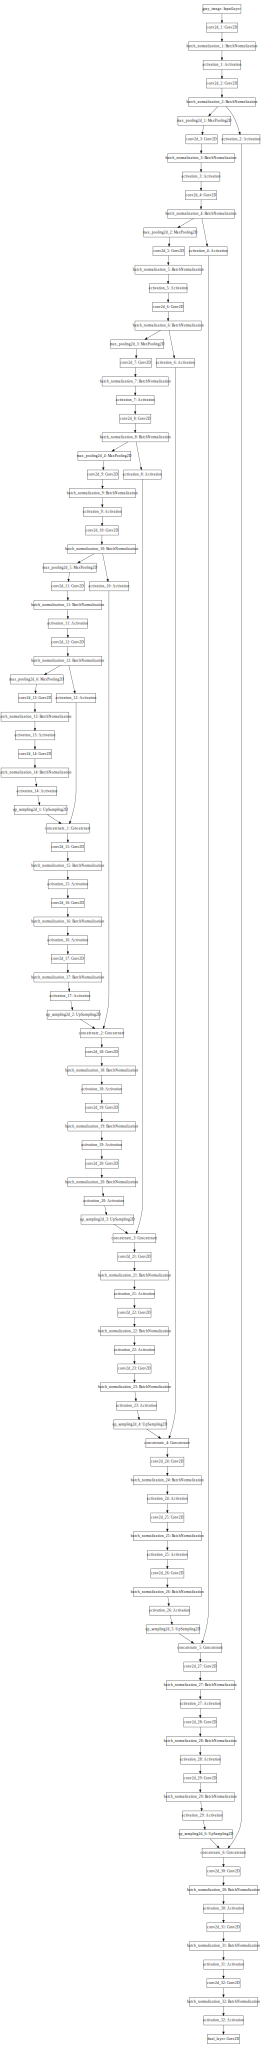

In [5]:
model = ImageColorizationModel()
model.model.summary()

# Vizualize
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model.model).create(prog='dot', format='svg'))

## Callback

## Training Model

In [9]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
import time
def train(model, lr, decay, batch_size, nb_epoch):
    # Helper: Save the model.
    timestamp = time.time()
    checkpointer = ModelCheckpoint(
        filepath=os.path.join('kth_data', 'checkpoints', model + '-' + \
            '.{epoch:03d}-{val_loss:.3f}.hdf5'),
        verbose=1,
        save_best_only=True)

    # Helper: TensorBoard
    tb = TensorBoard(log_dir=os.path.join('data', 'logs', model, str(timestamp)), write_images=True)

    # Helper: Stop when we stop learning.
    early_stopper = EarlyStopping(patience=10)

    # Helper: Save results.
    csv_logger = CSVLogger(os.path.join('kth_data', 'logs', model + '-' + 'training-' + \
        str(timestamp) + '.csv'))

    # Get the data and process it.
    data = Places256Dataset()
    generator = data.train_data_generator(batch_size)
    val_generator = data.val_data_generator(batch_size)

    # Get samples per epoch.
    # Multiply by 0.7 to attempt to guess how much of data.data is the train set.
    steps_per_epoch = (len(data.train_list) * 0.7) // batch_size //16
    steps_per_epoch = 1


    # Get the model.
    rm = ImageColorizationModel(lr=lr, decay=decay)


    rm.model.fit_generator(
      generator=generator,
      steps_per_epoch=steps_per_epoch,
      epochs=nb_epoch,
      verbose=1,
      callbacks=[tb, early_stopper],
      validation_data=val_generator,
      validation_steps=40,
      workers=4)
    return rm

In [15]:
batch_size = 8
nb_epoch = 10
lr = 5e-3
decay = 1e-4
trained_model = train('ImageColorization', lr, decay, batch_size=batch_size, nb_epoch=nb_epoch)

Epoch 1/10
1/1 [==============================] - 16s 16s/step - loss: 96.9520 - acc: 0.4918 - val_loss: 110.9727 - val_acc: 0.5725
Epoch 2/10
1/1 [==============================] - 11s 11s/step - loss: 115.9219 - acc: 0.4087 - val_loss: 110.2030 - val_acc: 0.5378
Epoch 3/10
1/1 [==============================] - 10s 10s/step - loss: 114.7550 - acc: 0.4347 - val_loss: 113.2088 - val_acc: 0.5569
Epoch 4/10
1/1 [==============================] - 10s 10s/step - loss: 113.8828 - acc: 0.4536 - val_loss: 112.0160 - val_acc: 0.5389
Epoch 5/10
1/1 [==============================] - 10s 10s/step - loss: 98.3646 - acc: 0.3229 - val_loss: 112.2795 - val_acc: 0.5667
Epoch 6/10
1/1 [==============================] - 11s 11s/step - loss: 104.5647 - acc: 0.3348 - val_loss: 113.4611 - val_acc: 0.5471
Epoch 7/10
1/1 [==============================] - 10s 10s/step - loss: 116.9215 - acc: 0.3841 - val_loss: 108.4454 - val_acc: 0.5507
Epoch 8/10
1/1 [==============================] - 10s 10s/step - loss: 

In [13]:
os.path.join('data/val_256', 't/tower/00000397')

'data/val_256/t/tower/00000397'